In [5]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  print("ok")
  pass

#%load_ext tensorboard
#%reload_ext tensorboard

ok


In [6]:
from sklearn.model_selection import train_test_split

# Load the preprocessed dataset
dataset = pd.read_csv("preprocessed_dataset.csv")

# Assuming you have text_messages and department_labels arrays
text_messages = dataset["Message"]
department_labels = dataset["Departement"]

# Convert department labels to numerical format
label_map = {label: index for index, label in enumerate(set(department_labels))}
numerical_labels = [label_map[label] for label in department_labels]

# Split dataset into training, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(
    text_messages, numerical_labels, test_size=0.3, random_state=42
)
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels, test_size=0.2, random_state=42
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_labels))

print("Train len: ", len(train_text))
print("Val len: ", len(val_text))
print("Test len: ", len(test_text))

Train len:  111
Val len:  38
Test len:  10


In [7]:
for example, label in train_dataset.take(3):
    print("text: ", example.numpy())
    print("label: ", label.numpy())

text:  b'pak kepareng matur mbok tulung pikiraken dalan wonosobo watumalang dalan kecamatan rekoso kok puluhan taun nganti pengen pindah provinsi sayang mboten saget'
label:  2
text:  b'jalan rusak parah di jalan utama jl kabupaten penghubung desa kaligowong wonosobo dengan desa pecekelan kabupaten kebumen mohon ditindaklanjuti pak sangat ingin jalan yang layak sudah hampir th lebih jalan rusak parah banget '
label:  2
text:  b'alamat kabupaten kota jakarta selatan kecamatan tebet kelurahan menteng dalam laporan asslamuallaikum pak ganjar perkenalkan nama saya vioranda raditya herkaputra ijin pak saya habis menonton cuplikan bapak terkait x jam akan ada respon apabila terjadi ketidakadilan pak ijin pak mobil saya dibawa lari oleh warga bapak di wonosobo atas nama anang sugiarto yang merupakan adik dari kepala desa sapuran wonosobo sejak tahun lalu saya mencoba melapor ke polres wonosobo tetapi tidak ada respon pak sudah beberapa kali bolak balik polres tapi terkesan tidak ada hasil seh

In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = (
    train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [9]:
for example, label in train_dataset.take(1):
    print("texts: ", example.numpy()[:3])
    print()
    print("labels: ", label.numpy()[:3])

texts:  [b'lapor pak ganjar di desa batursari sapuran wonosobo pamsimas menggunakan bendungan dari air kali kemungkinan air kali itu kotor karna saluran dari desa setempat mengalir ke kali itu setau saya pamsimas harus menggunakan sumber air asli pegunungan'
 b'jalan kepil bruno yg telah masuk kategori jalan propinsi amblas pada tgl sedalam kurang lebih cm'
 b'asllamualkaikum wr wb maf sblmnya saya ingn ksh infrmsi bawha msh ada pungli d wonosobo ini keluh kesah dri warga yang kena tilang di jalan hnya tidak pnya sim di kenakan tilang rb nominal yang tak sedikit menurut kami karna yg sudah hnya dpt denda rb katanya petugas jika sidang nominal sma dan jika ingin sidang saja maka motor akan di bawa petugas saya mau tanya apa benar hnya tak punya sim denda tilang rb apakah nominal tak punya sim c naik dri dlu yg rb jadi rb dan jika ingin sidang knp mtor harus di sita dan bnyak pula yang bayar di tempat dengan nominal trsebut trimakasih']

labels:  [2 1 0]


In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [12]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'saya', 'di', 'pak', 'dan', 'wonosobo', 'ada',
       'jalan', 'yg', 'tidak', 'yang', 'mohon', 'untuk', 'sudah', 'ke',
       'ini', 'dari', 'karena', 'biaya'], dtype='<U15')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

NameError: name 'example' is not defined

In [11]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

2024-04-19 17:51:53.617583: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:108 : INVALID_ARGUMENT: Index out of range using input dim 0; input has only 0 dims


InvalidArgumentError: Index out of range using input dim 0; input has only 0 dims [Op:StridedSlice] name: strided_slice/

In [13]:
total_train_samples = len(train_text)
total_val_samples = len(val_text)

# Calculate the number of epochs
# Assuming each epoch goes through the entire training dataset
num_epochs = 10

# Calculate steps per epoch
# Steps per epoch should be total_train_samples divided by batch size
steps_per_epoch = total_train_samples // BATCH_SIZE

# Calculate validation steps
# Validation steps should be total_val_samples divided by batch size
validation_steps = total_val_samples // BATCH_SIZE

print("Train len: ", len(train_text))
print("Val len: ", len(val_text))
print("Test len: ", len(test_text))
print("Steps per epoch:", steps_per_epoch)
print("Validation steps:", validation_steps)

Train len:  111
Val len:  38
Test len:  10
Steps per epoch: 1
Validation steps: 0


In [14]:
model = tf.keras.Sequential(
    [
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=64,
            # Use masking to handle the variable sequence lengths
            mask_zero=True,
        ),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(len(label_map), activation="softmax"),
    ]
)

In [15]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="Adam", metrics=["accuracy"]
)

history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=val_dataset,
    # validation_steps=1
)

Epoch 1/15
2/2 [==============================] - 34s 9s/step - loss: 1.0958 - accuracy: 0.4595 - val_loss: 1.0838 - val_accuracy: 0.6316
Epoch 2/15
2/2 [==============================] - 4s 1s/step - loss: 1.0857 - accuracy: 0.4955 - val_loss: 1.0686 - val_accuracy: 0.6316
Epoch 3/15
2/2 [==============================] - 3s 1s/step - loss: 1.0727 - accuracy: 0.4955 - val_loss: 1.0483 - val_accuracy: 0.6316
Epoch 4/15
2/2 [==============================] - 4s 2s/step - loss: 1.0563 - accuracy: 0.4955 - val_loss: 1.0197 - val_accuracy: 0.6316
Epoch 5/15
2/2 [==============================] - 4s 2s/step - loss: 1.0327 - accuracy: 0.4955 - val_loss: 0.9823 - val_accuracy: 0.6316
Epoch 6/15
2/2 [==============================] - 4s 1s/step - loss: 1.0033 - accuracy: 0.4955 - val_loss: 0.9384 - val_accuracy: 0.6316
Epoch 7/15
2/2 [==============================] - 4s 842ms/step - loss: 0.9680 - accuracy: 0.4955 - val_loss: 0.9067 - val_accuracy: 0.6316
Epoch 8/15
2/2 [=====================

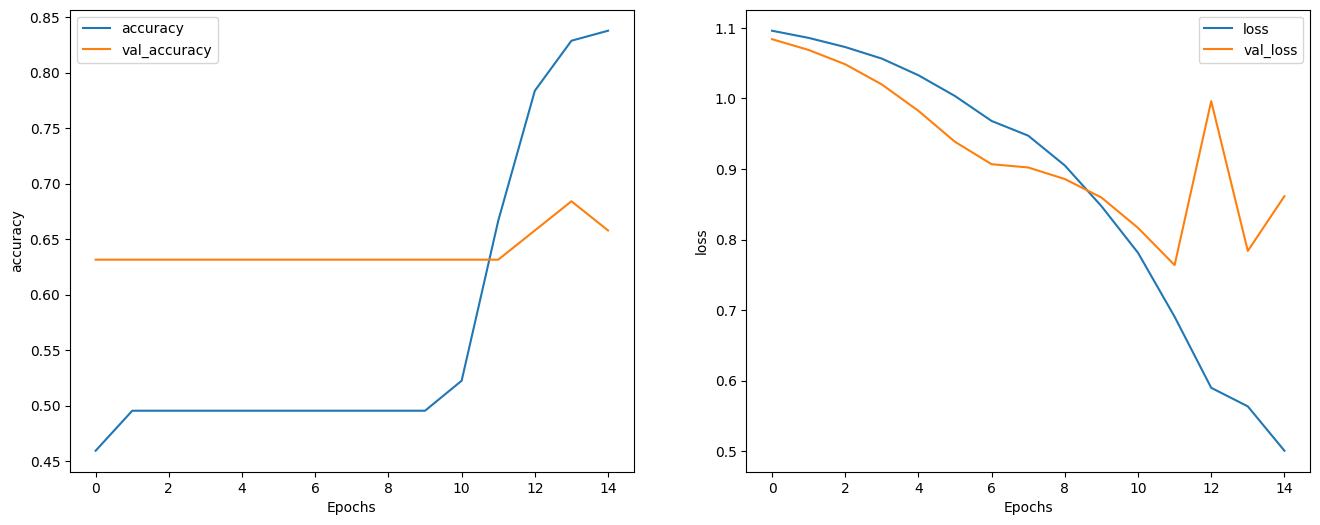

In [16]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_" + metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_" + metric])


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, "accuracy")
plt.subplot(1, 2, 2)
plot_graphs(history, "loss")

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

1/1 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.8000

1/1 [==============================] - 0s 124ms/step - loss: 0.5231 - accuracy: 0.8000
Test Loss: 0.5230833292007446
Test Accuracy: 0.800000011920929


In [19]:
# Retrieve a batch of text messages and labels from the test set
text_batch, label_batch = next(iter(test_dataset))

# Predict labels for the text batch
predictions = model.predict_on_batch(text_batch)

# Apply softmax to convert logits to probabilities
predictions_prob = tf.nn.softmax(predictions)

# Get the predicted class indices
predicted_class_indices = tf.argmax(predictions_prob, axis=1).numpy()

# Get the class probabilities
probabilities = predictions_prob.numpy()

# Define class names if available (replace with your actual class names)
class_names = [
    "dinas pekerjaan umum",
    "kepolisian daerah jawa tengah",
    "dinas kesehatan",
]  # Add your class names here

# Print the results for each text message
for i in range(len(text_batch)):
    print(f"Text: {text_batch[i].numpy().decode('utf-8')}")
    print(
        "True Label:", label_batch[i].numpy() + 1
    )  # Add 1 to match index with class label
    print("Predicted Label:", predicted_class_indices[i] + 1)
    print("Class Probabilities:")
    for j in range(len(probabilities[i])):
        print(f"{probabilities[i][j]} {class_names[j]}")
    print()

Text: perempatan kretek wonosobo macet terus pak ganjar pranowo ada pos polisi tapi g ada yg jaga mohon solusinya
True Label: 2
Predicted Label: 3
Class Probabilities:
0.29761382937431335 dinas pekerjaan umum
0.2811160683631897 kepolisian daerah jawa tengah
0.42127007246017456 dinas kesehatan

Text: jalan rusak parah yang menuju desa kepyar gumiwang tolong diperbaiki kasihan ibu hamil kendaraan yang melintas maaf saya ga bisa kirim gambar karna saya dijakarta
True Label: 3
Predicted Label: 3
Class Probabilities:
0.21968258917331696 dinas pekerjaan umum
0.21471145749092102 kepolisian daerah jawa tengah
0.5656059980392456 dinas kesehatan

Text: jalan provinsi yg menghuhungkan parakan wonosobo yg sudah bulan macet km setiap sore hari karena jembatan rusak tidak ada perbaikan coba dikunjungi pak ganjar pranowo
True Label: 3
Predicted Label: 3
Class Probabilities:
0.21740616858005524 dinas pekerjaan umum
0.2140342742204666 kepolisian daerah jawa tengah
0.5685595870018005 dinas kesehatan

Te

In [ ]:
sample_text = (
    "Text: bpkb motor saya hilang mau ngurus di polres wonosobo saya tanya biayanya sekitar apakah benar "
)
predictions = model.predict(np.array([sample_text]))
print(predictions)
# print(label_map)

# Get the predicted label with the highest probability
predicted_label_index = np.argmax(predictions)

print("Probability:", predictions[0][predicted_label_index])


# Function to get the key from a given value
def get_key_from_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None  # If value is not found in the dictionary


# Example usage
value_to_find = np.argmax(predictions)
key_for_value = get_key_from_value(label_map, value_to_find)
if key_for_value is not None:
    print("Numeric label", value_to_find, "is:", key_for_value)
else:
    print("Value", value_to_find, "not found in the dictionary.")

[[0.2112273  0.43140593 0.35736674]]
Probability: 0.43140593
Numeric label 1 is: kepolisian daerah jawa tengah


In [ ]:
print(label_map)

{'dinas pekerjaan umum bina marga cipta karya': 0, 'kepolisian daerah jawa tengah': 1, 'dinas kesehatan': 2}


In [ ]:
# Assuming you have a TextVectorization layer named 'encoder' and a model defined

# Set up a logs directory, so Tensorboard knows where to look for files.
log_dir = "/home/abdan/Desktop/Skripsi/[KODE] Tensorflow RNN/logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, "metadata.tsv"), "w") as f:
    # Get the vocabulary from the TextVectorization layer
    vocabulary = encoder.get_vocabulary()
    for word in vocabulary:
        f.write("{}\n".format(word))

# Save the weights of the Embedding layer
embedding_weights = model.layers[1].get_weights()[0]  # Assuming the Embedding layer is the second layer in your model
embedding_variable = tf.Variable(embedding_weights, name='embedding')
# Create a checkpoint from embedding
checkpoint = tf.train.Checkpoint(embedding=embedding_variable)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))


# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = "metadata.tsv"  # Update to just "metadata.tsv"
projector.visualize_embeddings(log_dir, config)


In [ ]:
# Now run tensorboard against on log data we just saved.
%tensorboard --logdir "/logs" --port 6006
notebook.display(port=6006, height=500)

Reusing TensorBoard on port 6006 (pid 98557), started 0:02:59 ago. (Use '!kill 98557' to kill it.)

Selecting TensorBoard with logdir /logs (started 0:02:59 ago; port 6006, pid 98557).


In [ ]:
from tensorboard import notebook
!pwd
# Get a list of active TensorBoard instances
tb_list = notebook.list()


/home/abdan/Desktop/Skripsi/[KODE] Tensorflow RNN
Known TensorBoard instances:
  - port 6006: logdir /logs (started 0:03:22 ago; pid 98557)
